In [53]:
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [ ]:
# Get Wine UCL Dataset
df = pd.read_csv('./winequality-white.csv', sep=';')

In [36]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


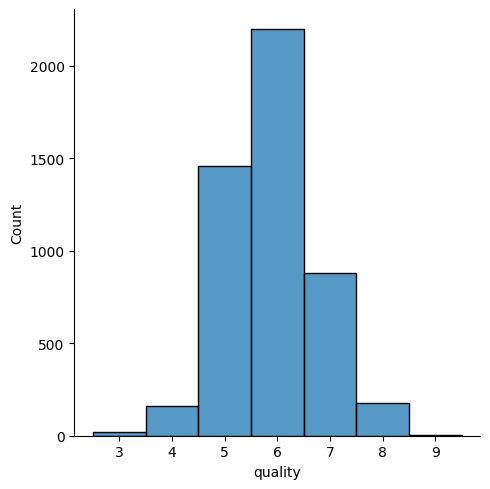

In [33]:
sns.displot(df, x='quality', discrete=True)

In [35]:
# Create a binary dataset derived (>6)
df_bin = df.copy()
df_bin.loc[:, 'quality'] = (df_bin['quality'] > 6).astype(int)

df_bin.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,0


In [37]:
df_train, df_test = train_test_split(df_bin, test_size=0.2)

In [38]:
# Naive Train / Test split.
X_train = df_train[df_train.columns.difference(['quality'])].to_numpy()
y_train = df_train['quality'].to_numpy()

X_test = df_test[df_test.columns.difference(['quality'])].to_numpy() 
y_test = df_test['quality'].to_numpy()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3918, 11)
y_train shape: (3918,)
X_test shape: (980, 11)
y_test shape: (980,)


# Ordinal Regression

We start with observations $y \in\{0,1\}$. The simplest probabilistic model for binary data is the Bernoulli distribution:

$$
y \sim \operatorname{Bernoulli}(p), \quad \text { with } \quad \mathbb{E}[y]=p
$$

where $p$ is the probability of observing $y = 1$

We will assume that this probability $p$ is linked to a set of feature $X \in \mathbb{R}^N$.
We also introduce a set of parameters $\omega \in \mathbb{R}^N$ and an intercept $b \in \mathbb{R}$ and 
posit the linear relationship. 
$$
\eta=X^{\top} \omega+b
$$

However, directly equating this linear predictor $\eta$ to the probability $p$ isn't possible since $p \in[0,1]$ and $\eta \in(-\infty, \infty)$.

We complete the link between $\eta$ and $p$ by introduce a (inverse) link function (which is a smooth, monotonic transformation) mapping $\eta$ to p: 
$$
p=f(\eta)=\frac{1}{1+e^{-\eta}}
$$
Above, we use logistic function as inverse link function. 
The logistic function ensures that $p \in(0,1)$

Given data $\left\{\left(X_i, y_i\right)\right\}_{i=1}^M$, the likelihood function is:

$$
L(\omega, b)=\prod_{i=1}^M \operatorname{Bernoulli}\left(y_i \mid p_i\right)=\prod_{i=1}^M p_i^{y_i}\left(1-p_i\right)^{1-y_i}
$$


To simplify calculations, we maximize the log-likelihood instead:

$$
(\hat{\omega}, \hat{b})=\arg \max _{\omega, b}\left[\sum_{i=1}^M \log \text { Bernoulli }\left(y_i \mid p_i\right)\right]
$$


Expanding explicitly:

$$
\ell(\omega, b)=\sum_{i=1}^M\left[y_i \log \left(p_i\right)+\left(1-y_i\right) \log \left(1-p_i\right)\right]
$$

where

$$
p_i=\frac{1}{1+e^{-\left(X_i^{\top} \omega+b\right)}}
$$


In [39]:
def logistic_fn(x):
    return 1 / ( 1 + np.exp(-x))

# Numerically stable sigmoid
def logistic_fn_stable(z):
    out = np.empty_like(z)
    positive = z >= 0
    negative = ~positive
    out[positive] = 1 / (1 + np.exp(-z[positive]))
    exp_z = np.exp(z[negative])
    out[negative] = exp_z / (1 + exp_z)
    return out

def nll(params, X, y):
    omega, b = params[:-1], params[-1]
    eta = np.einsum('i,bi->b', omega, X) + b
    p = logistic_fn_stable(eta) 
    p = np.clip(p, 1e-8, 1 - 1e-8)
    ll = y * np.log(p) + (1 - y) * np.log(1 - p)
    return -ll.sum()

In [40]:
initial_params = np.zeros(X_train.shape[1] + 1)

In [41]:
# Sanity check
nll(initial_params, X_train, y_train)

np.float64(2715.750653433866)

In [42]:
result = minimize(nll, initial_params, args=(X_train, y_train), method='BFGS')

In [43]:
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1639.8391454207017
        x: [ 8.346e-02 -1.363e+01 -1.105e+00 -7.084e+02  6.360e-01
             1.234e-02  3.744e+00  3.125e-01  2.158e+00 -8.366e-04
            -3.735e+00  6.839e+02]
      nit: 60
      jac: [-2.289e-04  2.289e-04  9.155e-05  6.104e-05 -1.068e-04
            -6.714e-04  3.052e-05 -1.526e-04  0.000e+00 -1.968e-03
            -4.578e-05 -1.526e-05]
 hess_inv: [[ 3.933e-03  2.099e-02 ...  9.693e-03  1.985e-02]
            [ 2.099e-02  1.152e-01 ...  5.290e-02  1.121e-01]
            ...
            [ 9.693e-03  5.290e-02 ...  2.465e-02  5.082e-02]
            [ 1.985e-02  1.121e-01 ...  5.082e-02  1.170e-01]]
     nfev: 2004
     njev: 153

In [48]:
def predict(params, X, threshold: float = 0.5):
    omega, b = params[:-1], params[-1]
    eta = np.einsum('i,bi->b', omega, X) + b
    probas = logistic_fn_stable(eta)
    return (probas >= threshold).astype(int)


def predict_proba(params, X, threshold: float = 0.5):
    omega, b = params[:-1], params[-1]
    eta = np.einsum('i,bi->b', omega, X) + b
    probas = logistic_fn_stable(eta)
    return probas

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

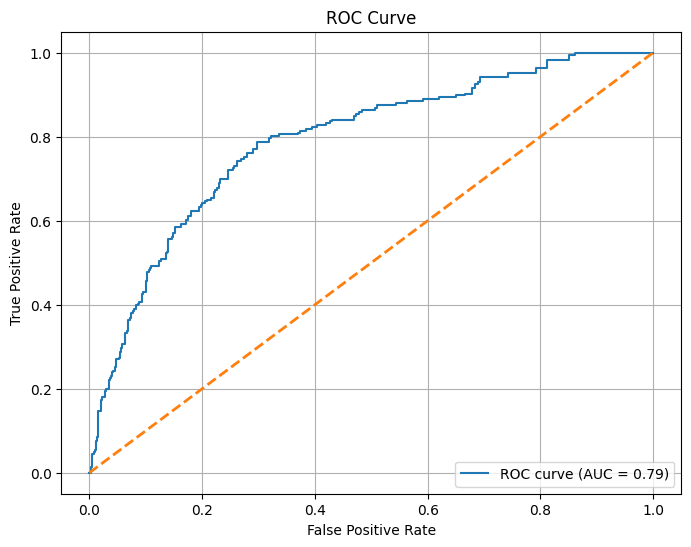

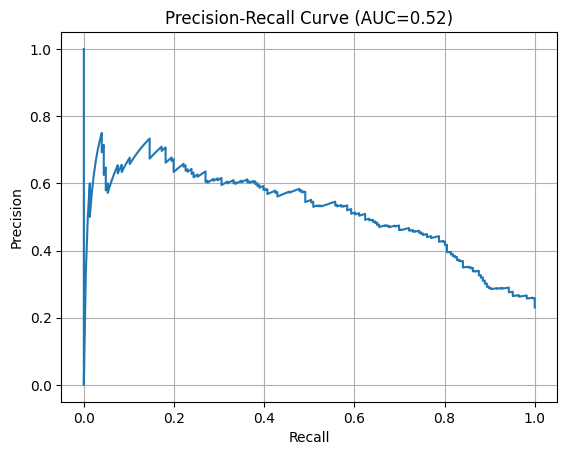

In [50]:
probas = predict_proba(result.x, X_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probas)
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={pr_auc:.2f})')
plt.grid()
plt.show()


# A different modeling approach (Ordinal)

The Probit Model with a latent variable threshold mechanism intuitively captures binary classification by assuming an underlying, unobserved (latent) continuous variable that reflects a propensity or inclination toward a particular outcome.

**1. Latent Propensity:**

Imagine each observation has a hidden "score" (z), influenced by features $X$. Higher scores represent greater inclination toward a positive outcome.

**2. Thresholding:**

We introduce a cutoff (typically at zero) to separate outcomes:
- If $z$ exceeds this threshold, we observe $y=1$.
- Otherwise, we observe $y=0$.

$$y= \begin{cases}0 & \text { if } z \leq \alpha \\ 1 & \text { if } z>\alpha\end{cases}$$

This process turns a continuous latent score into a binary decision.

**3. Probit Link Function  (Normal CDF):**

Because the latent scores $z$ are modeled as normally distributed, the probability of observing a positive outcome $(y=1)$ naturally becomes the area under the normal distribution curve to the right of the threshold.

Formally with ($\alpha = 0$):

$$
P(y=1 \mid X, \beta, b)=P(z>0)=1-\Phi\left(-X^{\top} \beta-b\right)=\Phi\left(X^{\top} \beta+b\right)
$$

The MLE objective becomes 

$$
(\hat{\beta}, \hat{b})=\arg \max _{\beta, b}\left[\sum_{i=1}^M y_i \log \Phi\left(X_i^{\top} \beta+b\right)+\left(1-y_i\right) \log \left(1-\Phi\left(X_i^{\top} \beta+b\right)\right)\right]
$$

Without the assumption of $\alpha = 0$:

$$ P(y=1 \mid X, \beta, b, \alpha)=P(z>\alpha)=1-\Phi\left(\alpha-X^{\top} \beta-b\right) $$

In this case, we would like to also optimze the threshold leading to more difficult loss function

$$
(\hat{\beta}, \hat{b}, \hat{\alpha})=\arg \max _{\beta, b, \alpha}\left[\sum_{i=1}^M y_i \log \Phi\left(X_i^{\top} \beta+b-\alpha\right)+\left(1-y_i\right) \log \left(1-\Phi\left(X_i^{\top} \beta+b\right)\right)\right]
$$

In [55]:
def probit_nll(params, X, y):
    beta, b = params[:-1], params[-1]
    eta = np.einsum('i,bi->b', beta, X) + b
    p = norm.cdf(eta)
    p = np.clip(p, 1e-8, 1 - 1e-8)
    ll = y * np.log(p) + (1 - y) * np.log(1 - p)
    return -ll.sum()

def predict_proba(params, X):
    beta, b = params[:-1], params[-1]
    eta = np.einsum('i,bi->b', beta, X) + b
    return norm.cdf(eta)

def predict(params, X, threshold=0.5):
    return (predict_proba(params, X) >= threshold).astype(int)

In [56]:
result = minimize(probit_nll, initial_params, args=(X_train, y_train), method='BFGS')

In [57]:
result.x

array([ 7.05064053e-02, -5.84282136e+00, -6.57342509e-01, -3.95068668e+02,
        3.47822093e-01,  6.06900576e-03,  2.00081330e+00,  1.78187520e-01,
        1.20441245e+00, -1.69323818e-04, -2.36074161e+00,  3.81430795e+02])

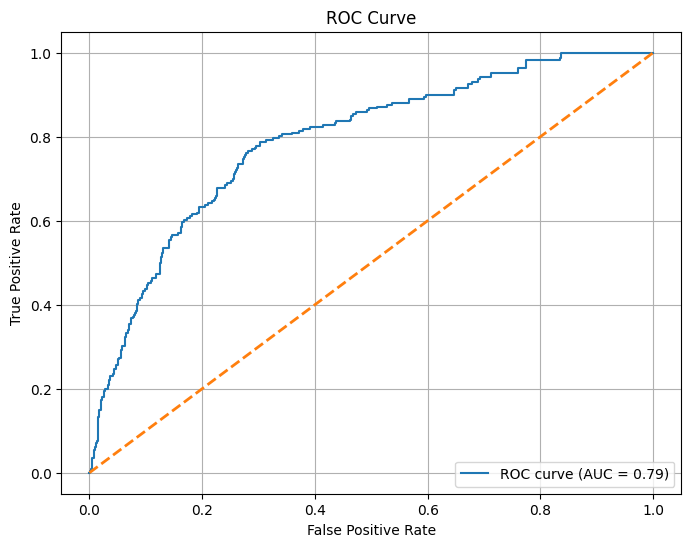

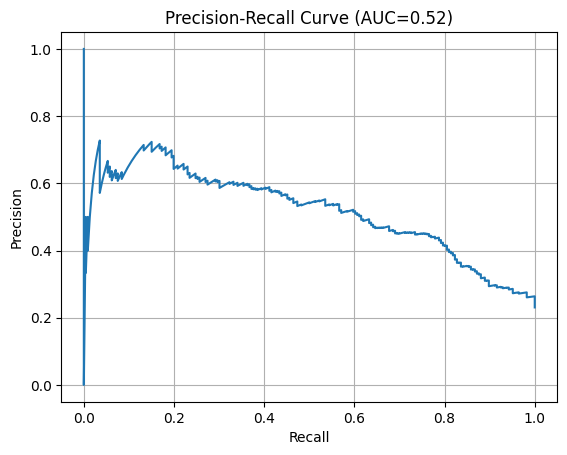

In [58]:
probas = predict_proba(result.x, X_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probas)
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={pr_auc:.2f})')
plt.grid()
plt.show()

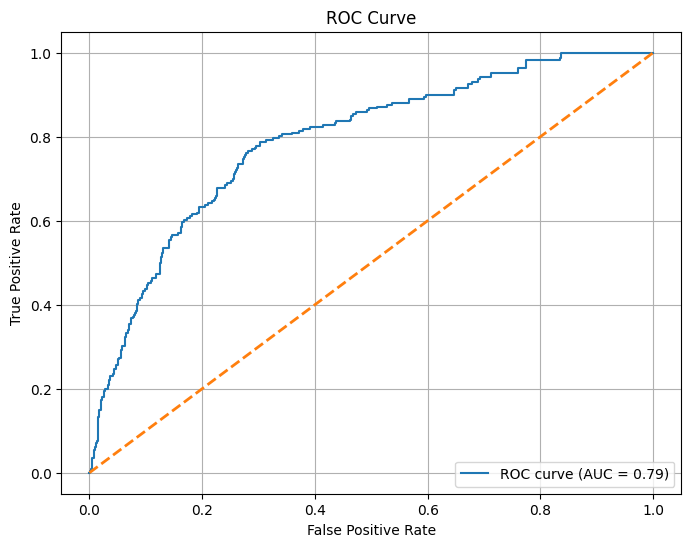

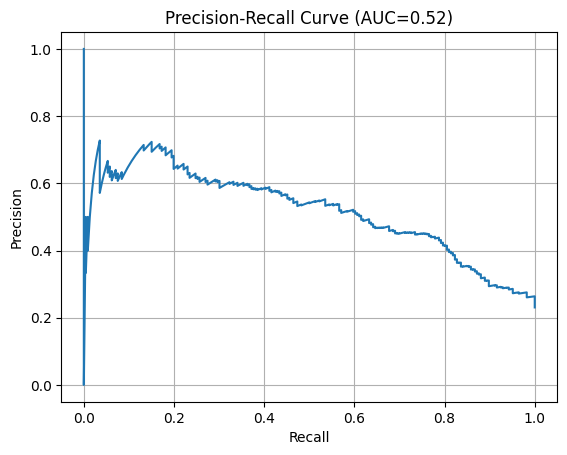

In [62]:
def probit_nll(params, X, y):
    beta, b, alpha = params[:-2], params[-2], params[-1]
    eta = np.einsum('i,bi->b', beta, X) + b
    p = norm.cdf(eta - alpha)
    p = np.clip(p, 1e-8, 1-1e-8)
    ll = y * np.log(p) + (1 - y) * np.log(1 - p)
    return -ll.sum()

# Example usage
initial_params = np.zeros(X_train.shape[1] + 2)
result = minimize(probit_nll, initial_params, args=(X_train, y_train), method='BFGS')
beta_hat, b_hat, alpha_hat = result.x[:-2], result.x[-2], result.x[-1]

def predict_proba(params, X):
    beta, b, alpha = params[:-2], params[-2], params[-1]
    eta = np.einsum('i,bi->b', beta, X) + b
    return norm.cdf(eta - alpha)

def predict(params, X, threshold=0.5):
    return (predict_proba(params, X) >= threshold).astype(int)


probas = predict_proba(result.x, X_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probas)
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={pr_auc:.2f})')
plt.grid()
plt.show()

In [63]:
result.x

array([ 7.05446391e-02, -5.84299284e+00, -6.57350774e-01, -3.95035568e+02,
        3.47796126e-01,  6.06902533e-03,  2.00070082e+00,  1.78175354e-01,
        1.20436448e+00, -1.69401867e-04, -2.36076582e+00,  1.90599503e+02,
       -1.90798654e+02])

# Ordinal Probit Model with Latent Variable and Threshold Mechanism

### Threshold Mechanism

The observed ordinal outcome $y \in\{1,2, \ldots, K\}$ is determined by comparing the latent variable $z$ to multiple ordered thresholds $\alpha_1<\alpha_2<\cdots<\alpha_{K-1}$ :

$$
y= \begin{cases}1 & \text { if } z \leq \alpha_1 \\ 2 & \text { if } \alpha_1<z \leq \alpha_2 \\ \vdots & \\ k & \text { if } \alpha_{k-1}<z \leq \alpha_k \\ \vdots & \\ K & \text { if } z>\alpha_{K-1}\end{cases}
$$

Given the latent structure, the probability of observing category $k$ is the probability that $z$ falls between two consecutive thresholds, $\alpha_{k-1}$ and $\alpha_k$. Formally, this is expressed as:

$$
P\left(y_i=k \mid X_i, \beta, b, \alpha\right)=P\left(\alpha_{k-1}<z \leq \alpha_k\right)=\Phi\left(\alpha_k-X_i^{\top} \beta-b\right)-\Phi\left(\alpha_{k-1}-X_i^{\top} \beta-b\right)
$$


Here, $\Phi$ denotes the cumulative distribution function (CDF) of the standard normal distribution. Intuitively, this captures the idea that the latent variable must lie within the specified thresholds for the observation to belong to category $k$.

Boundary conditions are:
- $\Phi(-\infty)=0$ and $\Phi(\infty)=1$.

In [90]:
df_proc  = df.copy()

# Transform the quality ratings to zero-indexed values (0-6 instead of 3-9)
# Get the unique categories in order
unique_qualities = np.sort(df_proc['quality'].unique())  # [3, 4, 5, 6, 7, 8, 9]

# Create a mapping dictionary from original values to indices
quality_to_idx = {quality: idx for idx, quality in enumerate(unique_qualities)}

# Create a new column with transformed values
df_proc['quality'] = df_proc['quality'].map(quality_to_idx)
df_train, df_test = train_test_split(df_proc, test_size=0.2)

X_train = df_train[df_train.columns.difference(['quality'])].to_numpy()
y_train = df_train['quality'].to_numpy()

X_test = df_test[df_test.columns.difference(['quality'])].to_numpy() 
y_test = df_test['quality'].to_numpy()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3918, 11)
y_train shape: (3918,)
X_test shape: (980, 11)
y_test shape: (980,)


In [103]:
def ordinal_probit_nll(params, X, y, K):
    n_features = X.shape[1]
    
    # Extract parameters
    beta = params[:n_features]  # Feature coefficients
    b = params[n_features]      # Intercept
    # Thresholds as cumulative sum of positive increments
    alpha_deltas = np.exp(params[n_features+1:])  # Ensure positive increments
    alphas = np.cumsum(np.concatenate(([0], alpha_deltas)))[:-1]  # K-1 thresholds
    
    # Linear predictor
    eta = np.einsum('ij,j->i', X, beta) + b
    
    # Bounds for each category
    lower_bounds = np.concatenate(([-np.inf], alphas))
    upper_bounds = np.concatenate((alphas, [np.inf]))
    
    # Probabilities
    prob = norm.cdf(upper_bounds[y] - eta) - norm.cdf(lower_bounds[y] - eta)
    prob = np.clip(prob, 1e-8, 1 - 1e-8)
    
    # Negative log-likelihood
    ll = np.sum(np.log(prob))
    return -ll

def predict_probas(params, X, K):
    n_features = X.shape[1]
    
    # Extract parameters the same way as in nll function
    beta = params[:n_features]  
    b = params[n_features]
    alphas = np.sort(params[n_features+1:])
    
    # Calculate linear predictor
    eta = np.einsum('ij,j->i', X, beta) + b
    
    # Set up bounds
    lower_bounds = np.concatenate(([-np.inf], alphas))
    upper_bounds = np.concatenate((alphas, [np.inf]))
    
    # Calculate probabilities for each category
    probas = np.zeros((X.shape[0], K))
    for k in range(K):
        probas[:, k] = norm.cdf(upper_bounds[k]) - norm.cdf(lower_bounds[k])
    
    return probas

def predict(params, X, K):
    probas = predict_probas(params, X, K)
    return np.argmax(probas, axis=1)

# Set up parameters
K = 7  # 7 wine quality categories
n_features = X_train.shape[1]  # 11 features

# Initialize parameters
# We need: n_features (beta) + 1 (intercept) + (K-1) (thresholds) = 11 + 1 + 6 = 18 parameters
initial_params = np.zeros(n_features + 1 + (K-1))

# Run optimization
result = minimize(ordinal_probit_nll, initial_params, args=(X_train, y_train, K), method='BFGS')

# Make predictions
probas = predict_probas(result.x, X_train, K)
predicted_classes = predict(result.x, X_test, K)

In [104]:
result.x

array([ 2.99878632e-01, -3.30320368e-02,  1.97730404e-02, -1.99604689e+02,
        1.11127107e-01,  7.32917542e-03,  9.72491918e-01,  1.10279241e-01,
        9.42808682e-01, -6.36212299e-04, -2.61336515e+00,  1.93879917e+02,
       -4.72490929e-02,  4.74568662e-01,  4.02970529e-01,  1.57598441e-01,
        4.60249714e-01,  0.00000000e+00])